In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [6]:
class ImageDataset(Dataset):
    def __init__(self, image_folder, excel_file, transform=None):
        self.image_folder = image_folder
        self.df = pd.read_excel(excel_file)
        self.image_names = self.df.iloc[:, 0].astype(str).values  # 图片名称
        self.performance_metrics = self.df.iloc[:, 2].values      # 性能指标
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, f"{img_name}")
        img = Image.open(img_path).convert("RGB")
        
        # 如果有图像变换操作，应用它们
        if self.transform:
            img = self.transform(img)
        
        # 获取对应的性能指标
        target = torch.tensor(self.performance_metrics[idx], dtype=torch.float32)
        return img, target


In [7]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        
        # 定义卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # 定义池化层
        self.pool = nn.MaxPool2d(2, 2)
        
        # 全连接层
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # 假设图片输入尺寸为128x128
        self.fc2 = nn.Linear(512, 1)  # 输出一个连续值
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        # 展平
        x = x.view(x.size(0), -1)
        
        # 全连接层
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整图片大小
    transforms.ToTensor(),          # 转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 数据集和数据加载器
image_folder = r'E:\daore1'
excel_file = r'E:\daore1\shuju.xlsx'  # 替换为你的文件名

dataset = ImageDataset(image_folder=image_folder, excel_file=excel_file, transform=transform)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
# 初始化模型、损失函数和优化器
model = CNNRegressor().cuda()  # 如果有 GPU，使用 CUDA 加速
criterion = nn.MSELoss()       # 使用均方误差损失
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # 设定为训练模式
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()  # 清空梯度
        outputs = model(inputs)  # 前向传播
        
        loss = criterion(outputs.squeeze(), targets)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        
        running_loss += loss.item()
    
    # 每个 epoch 结束时打印损失
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
# 在测试集上评估
model.eval()  # 设定为评估模式
predictions = []
targets = []

with torch.no_grad():
    for inputs, target in test_loader:
        inputs, target = inputs.cuda(), target.cuda()
        
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        targets.extend(target.cpu().numpy())

# 计算 MSE 和 R^2
predictions = np.array(predictions)
targets = np.array(targets)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(targets, predictions)
r2 = r2_score(targets, predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

D:\anaconda3\lib\site-packages\torch\nn\modules\module.py:911: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:30.)
  return self._apply(lambda t: t.cuda(device))


Epoch [1/100], Loss: 3.0567
Epoch [2/100], Loss: 0.0568
Epoch [3/100], Loss: 0.0173
Epoch [4/100], Loss: 0.0084
Epoch [5/100], Loss: 0.0067
Epoch [6/100], Loss: 0.0057
Epoch [7/100], Loss: 0.0058
Epoch [8/100], Loss: 0.0047
Epoch [9/100], Loss: 0.0039
Epoch [10/100], Loss: 0.0034
Epoch [11/100], Loss: 0.0031
Epoch [12/100], Loss: 0.0026
Epoch [13/100], Loss: 0.0024
Epoch [14/100], Loss: 0.0023
Epoch [15/100], Loss: 0.0035
Epoch [16/100], Loss: 0.0024
Epoch [17/100], Loss: 0.0019
Epoch [18/100], Loss: 0.0015
Epoch [19/100], Loss: 0.0017
Epoch [20/100], Loss: 0.0013
Epoch [21/100], Loss: 0.0012
Epoch [22/100], Loss: 0.0010
Epoch [23/100], Loss: 0.0011
Epoch [24/100], Loss: 0.0010
Epoch [25/100], Loss: 0.0009
Epoch [26/100], Loss: 0.0009
Epoch [27/100], Loss: 0.0010
Epoch [28/100], Loss: 0.0009
Epoch [29/100], Loss: 0.0006
Epoch [30/100], Loss: 0.0006
Epoch [31/100], Loss: 0.0006
Epoch [32/100], Loss: 0.0005
Epoch [33/100], Loss: 0.0004
Epoch [34/100], Loss: 0.0004
Epoch [35/100], Loss: 0

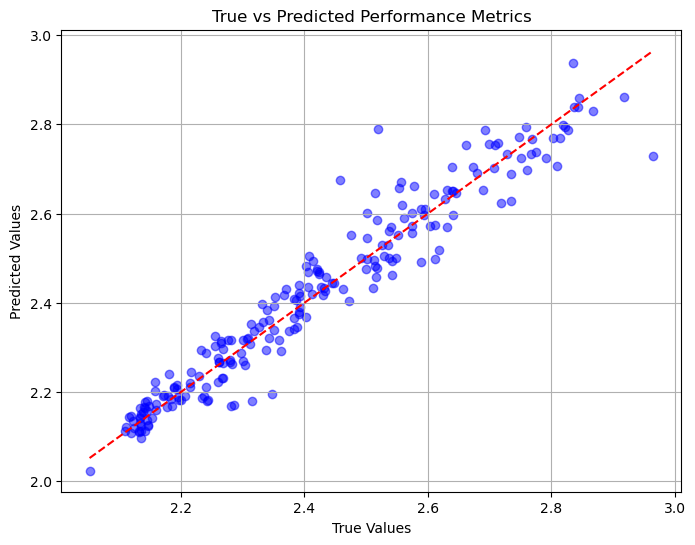

In [10]:
import matplotlib.pyplot as plt
model.eval()  # 设定为评估模式
test_preds = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        
        test_preds.extend(outputs.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# 绘制评估图：真实值 vs 预测值
plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, color='blue', alpha=0.5)
plt.plot([min(test_targets), max(test_targets)], [min(test_targets), max(test_targets)], color='red', linestyle='--')  # 参考线
plt.title('True vs Predicted Performance Metrics')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()